In [24]:
%run setup.py

In [2]:
t, y = np.loadtxt('../data/6780873_lc.txt', usecols=(0,1)).T

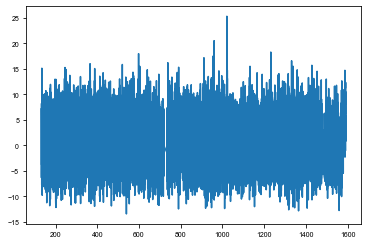

In [3]:
time, flux = t, (y-1)*1e3
freq = np.array([14.18764198, 13.43633836])
weights = np.array([1.73064022, 0.97161184])
plt.plot(time, flux)

In [4]:
period_guess, a_guess = 9.159, 18

# Periodogram

In [29]:
pg = ms.period_search()

In [30]:
periods = np.linspace(2, 20, 200)
results = pg.fit(periods)

100%|██████████| 200/200 [05:39<00:00,  1.70s/it]


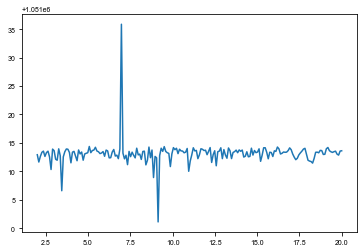

In [31]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods, -sm);

In [23]:
def get_phase(nu, t, y):
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan2(w[:len(nu)], w[len(nu):2*len(nu)]) / (2*np.pi*nu)

In [36]:
import tqdm
t0s = np.arange(time.min(), time.max(), 2.5)
phases = np.empty((len(t0s)-1, len(freq)))
phases[:] = np.nan
for i, t0 in tqdm.tqdm(enumerate(t0s[:-1]), total=len(t0s)-1):
    m = (t0 <= time) & (time < t0s[i+1])
    if m.sum() < 100:
        continue
    phases[i] = get_phase(freq, time[m], flux[m])
    
# phases -= np.nanmean(phases, axis=0)
full = np.mean(phases, axis=1)

100%|██████████| 583/583 [00:00<00:00, 2957.31it/s]


Text(0, 0.5, 'power')

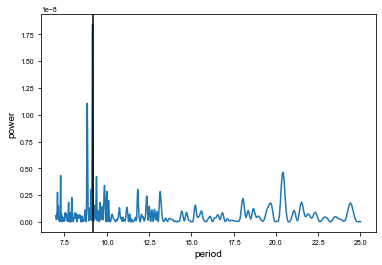

In [37]:
m = np.isfinite(phases[:, 0])
res = xo.estimators.lomb_scargle_estimator(t0s[:-1][m], full[m], min_period=7, max_period=25)
f, p = res["periodogram"]
period_guess = res['peaks'][0]['period']
plt.plot(1 / f, p)
plt.axvline(res["peaks"][0]["period"], color="k")
plt.xlabel("period")
plt.ylabel("power")

In [45]:
uHz_conv = 1e-6 * 24 * 60 * 60
tds = []
for freq, phase in zip(ms.freq, phases[m].T):
    phase = np.unwrap(phase)
    phase -= np.mean(phase)
    td = phase / (2*np.pi*(freq / uHz_conv * 1e-6))
    tds.append(td)

In [38]:
##### period_guess = res["peaks"][0]["period"]
arg = 2*np.pi*t0s[:-1][m]/period_guess
D = np.concatenate((np.sin(arg)[:, None],
                    np.cos(arg)[:, None],
                    np.ones((len(phases[m]), 1))), axis=-1)
w = np.linalg.solve(np.dot(D.T, D), np.dot(D.T, phases[m, 0]))
a_guess = np.sqrt(np.sum(w[:2]**2)) * 86400
period_guess, a_guess

(9.160772403859214, 15.229837526132492)

# Subdividing model

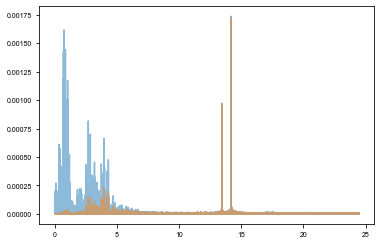

In [31]:
from scipy.ndimage import gaussian_filter
from maelstrom.utils import amplitude_spectrum
y_low = gaussian_filter(y,1.8)
y_high = y - y_low

plt.plot(*amplitude_spectrum(t, y), alpha=0.5)
plt.plot(*amplitude_spectrum(t, y_high), alpha=0.5)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c4f400b00>,
      dtype=object)

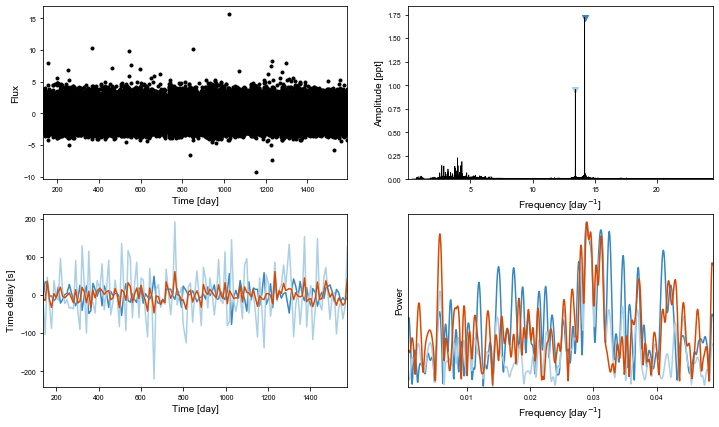

In [32]:
from maelstrom import Maelstrom

ms = Maelstrom(t, y_high, freq=freq)
ms.first_look()

In [33]:
td_time, td_td = ms.get_time_delay(segment_size=2.8)
td_td = np.average(td_td, weights=ms.get_weights(norm=False), axis=1)

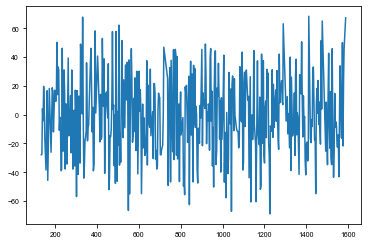

In [34]:
# td_time, td_td = np.loadtxt('../data/kic6780873_time-delay_Q99_llc.txt', delimiter=',', usecols=(0,1)).T
# td_time += 2400000
# td_time -= 2454833
#td_time -= np.median(td_time)
td_time = td_time[td_td< 70]
td_td = td_td[td_td < 70]

td_time = td_time[td_td>- 70]
td_td = td_td[td_td>-70]

# td_time -= np.median(td_time)
plt.plot(td_time, td_td)

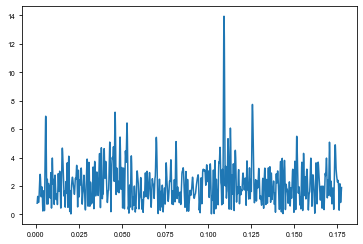

In [35]:
from maelstrom.utils import amplitude_spectrum
plt.plot(*amplitude_spectrum(td_time, td_td))

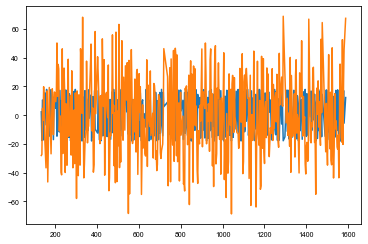

In [23]:
import theano.tensor as tt

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=0.5, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=10, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    phi = xo.distributions.Angle("phi", testval=0.22)
#     sinomega = pm.Uniform('sinomega', lower=-1, upper=1)
#     sinphi = pm.Uniform("sinphi", lower=-1, upper=1)
#     omega = pm.Uniform("omega", lower=-2*np.pi, upper=2*np.pi)
    mean = pm.Normal('mean', mu=0, sd=5, testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.05)
#     BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
#     eccen = BoundedBeta("eccen", alpha=0.867, beta=3.03, shape=1,
#                           testval=0.05)
    # The baseline flux
    #mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * td_time / period - phi
    
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(td_time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    tau = asini * psi
    tau += td_time * drift
    taumodel = pm.Deterministic('taumodel', tau - mean)
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    
    
    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.plot(td_time, td_td)

In [24]:
with subdivide_model:
    map_params = xo.optimize(vars=[mean])
    map_params = xo.optimize(vars=[logs_lc])
    map_params = xo.optimize(vars=[logasini, phi])
    map_params = xo.optimize(vars=[logs_lc])
    map_params = xo.optimize(vars=[eccen, omega])
    map_params = xo.optimize(vars=[logP])
    map_params = xo.optimize()

optimizing logp for variables: [mean]
5it [00:00,  6.84it/s, logp=-1.858227e+05] 
message: Optimization terminated successfully.
logp: -185871.60630944665 -> -185822.69253346324
optimizing logp for variables: [logs_lc]
17it [00:00, 138.25it/s, logp=-2.212268e+03]
message: Optimization terminated successfully.
logp: -185871.60630944665 -> -2212.2683155523277
optimizing logp for variables: [phi, logasini]
36it [00:00, 175.64it/s, logp=-1.610627e+05]
message: Optimization terminated successfully.
logp: -185871.60630944665 -> -161062.7233135249
optimizing logp for variables: [logs_lc]
17it [00:00, 133.64it/s, logp=-2.212268e+03]
message: Optimization terminated successfully.
logp: -185871.60630944665 -> -2212.2683155523277
optimizing logp for variables: [omega, eccen]
156it [00:00, 354.92it/s, logp=-1.629371e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -185871.60630944665 -> -162937.06805573768
optimizing logp for variables: [logP]
16it [00:00, 51.61it/

In [26]:
with subdivide_model:
    trace = pm.sample(draws=2000, start=map_params)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eccen, mean, phi, omega, drift, logasini, logs_lc, logP]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:37<00:00, 134.23draws/s]


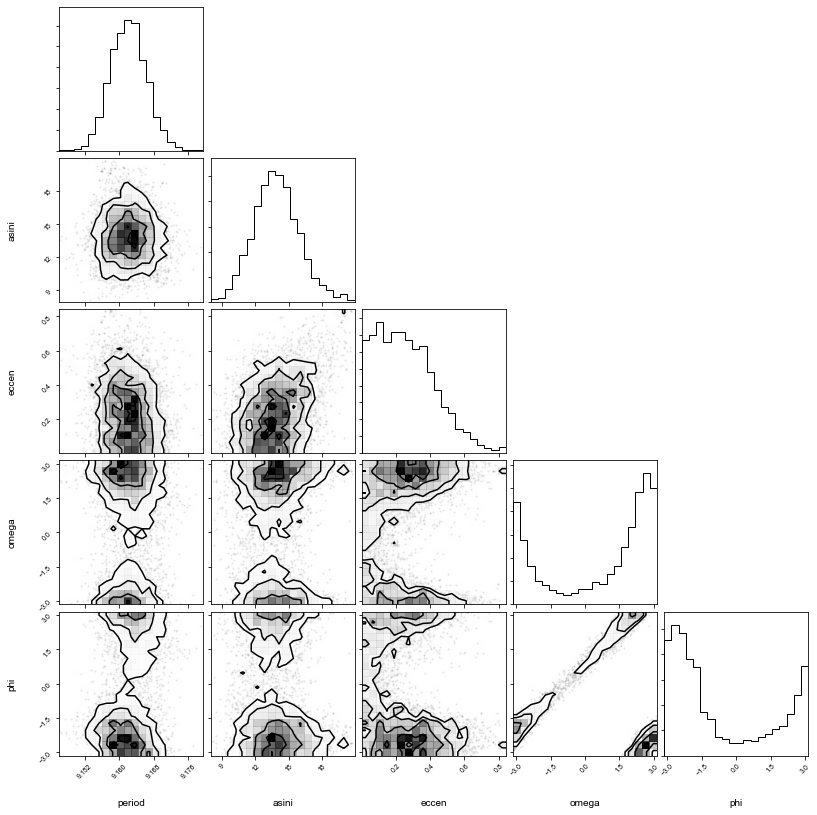

In [27]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['period', 'asini', 'eccen', 'omega', 'phi']));

In [28]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.034  +  0.018  -  0.012


In [29]:
phis = trace['omega']
phis[phis < 0] += 2*np.pi
np.median(phis)

upper, med, lower = np.percentile(phis, [84.13, 50, 15.86])
print(': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

:  2.725  +  1.005  -  1.028


In [30]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega']
rounding = 3
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  9.162  +  0.004  -  0.004
phi :  -1.774  +  4.211  -  0.942
eccen :  0.24  +  0.191  -  0.163
asini :  13.806  +  2.089  -  1.926
omega :  1.742  +  1.003  -  4.357


In [35]:
pm.save_trace(trace, 'traces/6780873_subdivided_final/', overwrite=True)

'traces/6780873_subdivided_final/'

Text(0, 0.5, 'Time delay (s)')

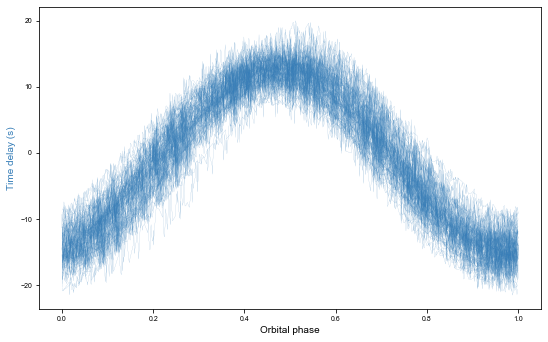

In [20]:

fig, ax = plt.subplots(figsize=mnras_size(540), constrained_layout=True)

with subdivide_model:
    for samp in xo.utils.get_samples_from_trace(trace, size=100):
        #taumod = xo.eval_in_model(asini * psi, samp)
        ttime = (td_time) % samp['period'] / samp['period']
        tau = samp['taumodel']
        
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], tau[sort], linewidth=0.1, alpha=1, color=blue)
        #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
        #ttime = (ms.time_mid + time) % samp['period'] / samp['period']
        #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
        #sort = np.argsort(ttime)
        #ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.1, alpha=1, rasterized=True)
        
    
#a, b = ms.get_time_delay(segment_size=10)
#bb = np.average(b, axis=1, weights=ms.get_weights())
#plt.plot((a + ms.time_mid) % np.median(trace['period']) / np.median(trace['period']) ,bb, '.k', markersize=2)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)

#ax.set_xlim(0, 1)

#plt.savefig(overleaf_path + '6780873.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Maelstrom

In [2]:
rv_jd, rv_rv, rv_err = np.loadtxt('../../data/kic6780873_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd += 2400000
rv_jd -= 2454833

time, mag = np.loadtxt('../../data/kic6780873_lc.txt', usecols=(0,1)).T
time += 2400000
time -= 2454833
time, mag = time, mag*1e3

freq = np.array([14.18764198, 13.43633836])

In [5]:
with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=1, upper=12)("P", mu=9.159153, sd=5,
                                     shape=1, testval=9.159153)

    # Wide log-normal prior for semi-amplitude
    logasini = pm.Bound(pm.Normal, lower=1, upper=25)("logasini", mu=np.log(17.441530), sd=10,
                                        shape=1, testval=np.log(17.441530))
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(mag)), sd=10, testval=0.)
    asini = pm.Deterministic('asini', tt.exp(logasini))
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.27)
    omega = xo.distributions.Angle("omega", testval=2.306092)
    phi = xo.distributions.Angle('phi', testval=0.377081)
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    
    orbit = Orbit(period=P, 
              lighttime=asini, 
              omega=omega, 
              eccen=ecc, 
              phi=phi, 
              freq=nu)
    
    lc = orbit.get_lightcurve_model(time, mag)
    
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=2.58269602)
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=100, testval=10.88269047)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    gp_l = gp.log_likelihood(mag - lc)
    # Weight likelihood equally with RV data
    pm.Potential("obs", gp_l)
    
#     pm.Normal('obs', mu=lc, sd=tt.exp(logs_lc), observed=mag)

In [ ]:
with model:
    all_but = [v for v in model.vars if v.name not in ["P_interval__"]]
    map_params = xo.optimize(start=None, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[ecc, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params,
                             vars=all_but
                            )

    map_params = xo.optimize(start=map_params, vars=[P])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )

In [ ]:
fig, axes = plt.subplots(3,1, figsize=[3.33333, 2.06*2.3], gridspec_kw={'height_ratios': [1,1,0.3]}, constrained_layout=True)
from maelstrom.utils import amplitude_spectrum
with model:
    ax = axes[0]
    ax.plot(*amplitude_spectrum(time, xo.eval_in_model(lc, map_params)),
            c=blue, alpha=1, linewidth=0.8, label='Maelstrom')
    ax.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict(), map_params)),
            c=red, alpha=1, linewidth=0.8, label='GP')
    ax.set_xlim(0,24)
    ax.set_ylim(0, None)
    ax.legend()
    
    #ax.plot(*amplitude_spectrum(time, flux), alpha=0.2, c='green')
    
    ax.set_xlabel('Frequency (d$^{-1}$)')
    ax.set_ylabel('Amplitude (ppt)')
    
    
    ax = axes[1]
    med = xo.eval_in_model(gp.predict() + lc, map_params)
    ax.plot(time, med , c=blue, alpha=1, linewidth=0.8, rasterized=True)
    ax.plot(time, mag, '.k', markersize=2, rasterized=True)
    ax.set_xlim(200,205)
    ax.set_ylim(-16.2,16.2)
    ax.set_xticks([])
    ax.set_ylabel('Amplitude (ppt)')
    
    ax = axes[2]
    ax.plot(time, med - mag, '.k',
            c=blue, alpha=1, linewidth=0.7, label='Light curve model', markersize=2, rasterized=True)
    ax.set_xlim(200,205)
    ax.set_ylim(-1,1)
    ax.set_xlabel('Time (BKJD)')
    ax.set_ylabel('Res.')
    
# plt.savefig(overleaf_path + '6780873_lc_model.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000, 
        draws=2000, 
        step=xo.get_dense_nuts_step(target_accept=0.9), 
        start=map_params
    )
    
pm.save_trace(trace,'traces/NEW/6780873_PM')

In [6]:
with model:
    trace = pm.load_trace('traces/NEW/6780873_PM')

In [7]:
varnames = ["P", "asini", "ecc", "omega", "phi"]
for var in varnames:
    percentiles = np.percentile(trace[var], q=[15.87, 50, 84.13])
    print(f'{var}: {percentiles[0]:.3f} + {percentiles[1] - percentiles[0]:.3f} - {percentiles[2] - percentiles[1]:.3f}')

P: 9.158 + 0.002 - 0.002
asini: 18.412 + 1.570 - 2.086
ecc: 0.462 + 0.123 - 0.148
omega: 0.936 + 0.284 - 0.280
phi: -0.956 + 0.221 - 0.214


In [11]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-2.088905,1.402644e-02,1.720500e-04,-2.115719,-2.060659,7240.070360,1.000708
lognu__0,2.652371,2.453881e-08,3.093817e-10,2.652371,2.652371,6738.366985,1.000033
lognu__1,2.597963,5.149372e-08,6.081741e-10,2.597963,2.597963,9137.483001,0.999998
logpower,10.883107,8.404663e-03,9.944582e-05,10.866739,10.899843,6366.254270,1.000175
P__0,9.159635,1.937280e-03,3.119742e-05,9.155991,9.163541,3581.719504,1.002529
logasini__0,3.011819,1.291883e-01,7.419872e-03,2.796514,3.233713,146.525318,1.020908
asini__0,20.514776,3.185282e+00,2.078277e-01,16.209346,25.161081,114.552317,1.024419
ecc__0,0.598987,1.478953e-01,5.510546e-03,0.382934,0.998002,367.032416,1.011593
omega,1.219092,2.793418e-01,7.528399e-03,0.676886,1.769429,1053.314433,1.000794
phi,-0.737635,2.222113e-01,3.436974e-03,-1.199479,-0.324077,4444.393147,1.000072


In [17]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['P', 'asini'])
mfs = mass_function(samples['P__0'].values * u.day, samples['asini__0'].values*u.s)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.102  +  0.035  -  0.022


# Maelstrom + RV

In [3]:
with pm.Model() as model:
    period = pm.Bound(pm.Normal, lower=0, upper=12)("P", mu=9.159153, sd=5,
                                     shape=1, testval=9.159153)

    logasini = pm.Bound(pm.Normal, lower=0, upper=25)("logasini", mu=np.log(17.441530), sd=10,
                                        shape=1, testval=np.log(17.441530))
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(mag)), sd=10, testval=0.)
    asini = pm.Deterministic('asini', tt.exp(logasini))
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.27)
    omega = xo.distributions.Angle("omega", testval=2.306092)
    phi = xo.distributions.Angle('phi', testval=0.377081)
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    
    orbit = Orbit(period=period, 
              lighttime=asini, 
              omega=omega, 
              eccen=ecc, 
              phi=phi, 
              freq=nu)
    
    lc = orbit.get_lightcurve_model(time, mag)
    
#     # GP
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=2.58269602)
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=100, testval=10.88269047)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    gp_l = gp.log_likelihood(mag - lc)
    pm.Potential("obs", gp_l)
    
#     pm.Normal('obs', mu=lc, sd=tt.exp(logs_lc), observed=mag)
    
    # RV data:
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=11.)
    logs_rv = pm.Normal('logs_rv', mu=np.log(np.std(rv_rv)), sd=10, testval=np.log(np.std(rv_rv)))
    vrad = orbit.get_radial_velocity(rv_jd)
    vrad += gammav # Systemic velocity

    err = tt.sqrt(2*rv_err**2 + tt.exp(2*logs_rv))
    pm.Normal("obs_rv", mu=vrad, sd=err, observed=rv_rv)

In [ ]:
with model:
    map_params = xo.optimize(start=model.test_point, vars=[gammav])
    map_params = xo.optimize(start=map_params, vars=[phi])
    
    all_but = [v for v in model.vars if v.name not in ["period_interval__"]]
    map_params = xo.optimize(start=None, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[ecc, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params,
                             vars=all_but
                            )

    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )

In [ ]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000, 
        draws=2000, 
        step=xo.get_dense_nuts_step(target_accept=0.9), 
        start=map_params
    )
    
pm.save_trace(trace,'traces/NEW/6780873_PM_RV', overwrite=True)

In [4]:
with model:
    trace = pm.load_trace('traces/NEW/6780873_PM_RV')

In [5]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-2.088730,1.396678e-02,1.903693e-04,-2.116030,-2.061459,6001.282092,0.999942
lognu__0,2.652371,2.457592e-08,3.085551e-10,2.652371,2.652371,7732.653228,1.000565
lognu__1,2.597963,5.129832e-08,5.864659e-10,2.597963,2.597963,7623.297915,0.999861
logpower,10.883270,8.538375e-03,1.065216e-04,10.866703,10.899908,6377.475903,1.000136
logs_rv,0.125434,5.144415e-01,1.635629e-02,-0.810245,1.149891,929.913054,1.001805
P__0,9.159180,8.269698e-04,1.266614e-05,9.157564,9.160767,5302.086684,1.001002
logasini__0,2.856926,4.234440e-02,8.064314e-04,2.776262,2.944638,2287.161016,0.999883
asini__0,17.423652,7.454177e-01,1.408879e-02,16.058877,19.003777,2293.389661,0.999862
ecc__0,0.106880,6.010785e-02,1.847468e-03,0.012186,0.188531,890.994974,1.001453
omega,2.301263,5.068044e-01,2.114785e-02,1.674055,2.836510,557.313215,1.002160


In [28]:
from tqdm import tqdm

tds, rvs = [], []
with model:
    for samp in tqdm(xo.utils.get_samples_from_trace(trace, size=1000), total=1000):
        tds.append(xo.eval_in_model(orbit.get_time_delay(time), samp))
        rvs.append(xo.eval_in_model(orbit.get_radial_velocity(time) + gammav, samp))

100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]


In [29]:
med_td = np.median(tds, axis=0)
sd_td = np.std(tds, axis=0)
med_rv = np.median(rvs, axis=0)
sd_rv = np.std(rvs, axis=0)

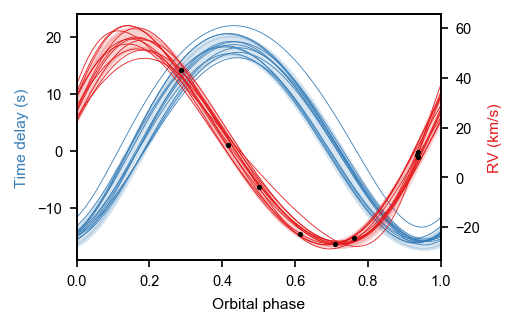

In [38]:
fig, ax = plt.subplots(figsize=mnras_size(240), constrained_layout=True)
ax2 = ax.twinx()

np.random.seed(42)

with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=12):
        times = time# + xo.eval_in_model(phi * period / (2*np.pi), samp)
        fold = times % samp['P'] / samp['P']
        sort = np.argsort(fold)
        ax.plot(fold[sort], xo.eval_in_model(orbit.get_time_delay(time), samp)[sort] * 86400, color=blue, alpha=1., linewidth=0.4)
        
        times = time# + xo.eval_in_model(phi * period / (2*np.pi), samp)
        fold = times % samp['P'] / samp['P']
        sort = np.argsort(fold)
        ax2.plot(fold[sort], xo.eval_in_model(orbit.get_radial_velocity(time) + gammav, samp)[sort], color=red, alpha=1., linewidth=0.4)
        
ax2.plot(rv_jd % np.median(trace['P']) /  np.median(trace['P']), rv_rv, '.', c='black', label='RV data', rasterized=True, zorder=50, markersize=3)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)

ax2.set_ylabel('RV (km/s)', c=red)
ax.set_xlim(0, 1)

times = time# + xo.eval_in_model(phi * period / (2*np.pi), samp)
fold = times % np.median(trace['P']) / np.median(trace['P'])
sort = np.argsort(fold)
# plt.plot(fold[sort], med[sort] * 86400, color=blue, alpha=1., linewidth=0.2)
ax.fill_between(fold[sort], (med - sd)[:,0][sort] * 86400, (med+sd)[:,0][sort] * 86400, alpha=0.2, color=blue)
ax2.fill_between(fold[sort], (med_rv - sd_rv)[sort], (med_rv+sd_rv)[sort], alpha=0.2, color=red)

plt.savefig(overleaf_path + '6780873.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [22]:
varnames = ["P", "asini", "ecc", "omega", "phi"]
for var in varnames:
    percentiles = np.percentile(trace[var], q=[15.87, 50, 84.13])
    print(f'{var}: {percentiles[0]:.3f} + {percentiles[1] - percentiles[0]:.3f} - {percentiles[2] - percentiles[1]:.3f}')

P: 9.158 + 0.001 - 0.001
asini: 16.742 + 0.623 - 0.734
ecc: 0.065 + 0.034 - 0.041
omega: 2.152 + 0.213 - 0.170
phi: 0.169 + 0.213 - 0.187


In [26]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['P', 'asini'])
mfs = mass_function(samples['P__0'].values * u.day, samples['asini__0'].values*u.s)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.067  +  0.009  -  0.007
